In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from copy import deepcopy
##-------------------------------PRE PROCESSING---------------------------------##
## meshing --------------------------------------------------------
class setup:
    def __init__(self,nelx,nely,width,heigth,E,nu):
        self.el_width= width/nelx 
        self.el_heigth= heigth/nely
        self.heigth=heigth
        self.width=width
        self.E=E
        self.nu=nu
        self.nelx=nelx
        self.nely=nely
        self.nnodes=(nelx+1)*(nely+1)
        self.nels=nelx*nely
                
        self.coordx=np.linspace(0,width,nelx+1)
        self.coordy=np.linspace(0,heigth,nely+1)
        coord=np.zeros(((nelx+1)*(nely+1),2))
        etpl=np.zeros(((nelx)*(nely),4))
        all_dofs= np.arange((nelx+1)*(nely+1)*2)
        
        # calculate coordinates of global nodes :
        idx=0
        for j in range(nely+1):
            for i in range(nelx+1):
                coord[idx,:]=np.array([self.coordx[i],self.coordy[j]])
                idx=idx+1        
        # calculate connectivity matrix etpl :
        idx=0
        etplall=np.arange((1+nely)*(1+nelx)).reshape((nely+1,nelx+1))
        for i in range(nely):
            for j in range(nelx):        
                 etpl[idx]=np.array([etplall[i,j],etplall[i,j+1], \
                                     etplall[i+1,j+1],etplall[i+1,j]])
                 idx=idx+1  
        # element topology or connectivity matrix
        etpl=etpl.astype(int)
        
        self.etpl=etpl
        self.coord=coord
        self.all_dofs=all_dofs

        self.D=E/(1-nu**2)*np.array([[1,nu,0],[nu,1,0],[0,0,(1-nu)/2]])
        self.allgp=(1/3)**0.5*np.array([[-1,1,1,-1],[-1,-1,1,1]])
        self.J=np.array([[(0.5*width/nelx)/1,0],[0,(0.5*heigth/nely)/1]])
        self.Det=np.linalg.det(self.J)
##------------------------------- PROCESSING ------------------------------------##
## shape functions derivatives matrix -------------------------
   ## derivatives matrix  :
    def B(self,x,y):
        output= 1/4 * \
                np.array([[y-1,0,1-y,0,y+1,0,-1-y,0], \
                          [0,x-1,0,-1-x,0,x+1,0,1-x], \
                     [x-1,y-1,-1-x,1-y,x+1,y+1,1-x,-1-y]])
        output[0,:]=output[0,:]/(self.el_width/2) 
        output[1,:]=output[1,:]/(self.el_heigth/2)
        output[2,::2]=output[2,::2]/(self.el_heigth/2)
        output[2,1::2]=output[2,1::2]/(self.el_width/2)
        return output

## element stiffness matrix ----------------------------------------------------
    def ke(self):
        kei=np.zeros((8,8))
        for gp in range(4):
            x=self.allgp[0,gp]
            y=self.allgp[1,gp]
            kei=kei+1*self.Det*np.matmul(np.transpose(self.B(x,y)),np.matmul(self.D,self.B(x,y)))
        return kei

    def kbase(self):
        Kbase=np.zeros((self.nnodes*2,self.nnodes*2))
        ke=self.ke() #put at the begining to call it only once
        etpl=self.etpl
        for i in range(self.nels): #nels
            for row in range(4):
                for col in range(4):
                    indr=etpl[i][row]*2; indc=etpl[i][col]*2
                    Kbase[indr:(indr+2),indc:(indc+2)]=Kbase[indr:(indr+2),indc:(indc+2)] + \
                                                   ke[row*2:(row*2+2),col*2:(col*2+2)]
        return Kbase

## Processing functions -----------------------------------------
class output:
    def __init__(self,setup,Kbase,BC_dofs,BC_val,P_horiz,P_vert,d1,d2):
        coord=setup.coord
        D=setup.D
        nu=setup.nu
        E=setup.E
        heigth=setup.heigth
        width=setup.width
        nelx=setup.nelx
        nely=setup.nely
        all_dofs=setup.all_dofs

        ## you can re-run this part after having chosen different values of stress with picking
        K=deepcopy(Kbase)

 ### in case we need the theoretical deforation of a rectangular solid:
        exx=nu*np.average(P_vert)/E; # strain in horizontal direction
        eyy=np.average(P_vert)/E; # strain in vertical direction
        dxy=heigth*np.average(P_horiz)/(E/(2*(1+nu))) # shear displacement (horizontal direction)


        ## initialize force vector
        F=np.zeros(((nelx+1)*(nely+1)*2,1))

        ## assemble degrees of freedom
        bot_nodes=np.where(coord[:,1]==0)[0]
        dofs0=bot_nodes*2  # dofs x direction
        dofs1=bot_nodes*2+1  # dofs y direction 
        right_nodes=np.where(coord[:,0]==width)[0]
        dofs2=right_nodes*2  # dofs x direction
        dofs3=right_nodes*2+1  # dofs y direction         
        top_nodes=np.where(coord[:,1]==heigth)[0]
        dofs4=top_nodes*2  # dofs x direction
        dofs5=top_nodes*2+1  # dofs y direction 
        left_nodes=np.where(coord[:,0]==0)[0]
        dofs6=left_nodes*2  # dofs x direction
        dofs7=left_nodes*2+1  # dofs y direction 

        #extra_dofs:
        nodes_11=np.where(coord[:,0]==0)[0]
        nodes_12=np.where(coord[nodes_11,1]<=d1)[0]
        nodes_1=nodes_11[nodes_12]
        dofs8=nodes_1*2  # dofs x direction
        dofs9=nodes_1*2+1  # dofs y direction

        nodes_21=np.where(coord[:,0]==width)[0]
        nodes_22=np.where(coord[nodes_21,1]>=(heigth-d2))[0]
        nodes_2=nodes_21[nodes_22]
        dofs10=nodes_2*2  # dofs x direction
        dofs11=nodes_2*2+1  # dofs y direction
        
        dofs_BC=[dofs0,dofs1,dofs2,dofs3,dofs4,dofs5,dofs6,dofs7,dofs8,dofs9,dofs10,dofs11] ##all dofs on Boundaries as shown on drawing
        # +4 extra dofs groups
        
        nmn_dofs=np.concatenate(np.array(dofs_BC)[BC_dofs[1]])
        f=[];
        for expr in BC_val[1]:  
            f=np.concatenate((f,eval(expr)))
        F[nmn_dofs,0]=f

        d=[];
        for expr in BC_val[0]:
            d=np.concatenate((d,eval(expr)))

        fixed_dofs=np.concatenate(np.array(dofs_BC)[BC_dofs[0]])
        free_dofs=all_dofs[np.in1d(all_dofs, fixed_dofs,invert=True)]

        for id in range(len(fixed_dofs)):
            i=fixed_dofs[id];
            rows=K[free_dofs,i];
            F[free_dofs,0]=F[free_dofs,0]-rows*d[id];
            K[:,i]=0; K[i,:]=0; K[i,i]=1;
            F[i]=d[id];

        ## solve the system with a sparse matrix ------------------------------------------
        Ksp = csr_matrix(K)
        U= spsolve(Ksp,F)

        ##-------------------------------POST PROCESSING------------------------------------##
        ## Calculate stresses ----------------------------------------------------------------
        sigma=np.zeros((nely+1,nelx+1,3))
        ux_mat=U[::2].reshape((nely+1, nelx+1))
        uy_mat=U[1::2].reshape((nely+1, nelx+1))
        Du=np.gradient(ux_mat,setup.el_heigth,setup.el_width);
        Dv=np.gradient(uy_mat,setup.el_heigth,setup.el_width);
        Bstress=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1]]);
        for i in range(nely+1):
            for j in range(nelx+1):
                strain=np.matmul(Bstress,np.array([[Du[1][i,j]],[Dv[0][i,j]],[Dv[1][i,j]],[Du[0][i,j]]]));
                stress=np.matmul(D,strain);
                sigma[i,j,0]=stress[0]; # 0 for syy
                sigma[i,j,1]=stress[1]; # 1 for sxx
                sigma[i,j,2]=stress[2]; # 2 for tauxy
        
        self.U=U
        self.sigma=sigma
        self.shear_half=sigma[:,:,2][int(nely/2+1),:]
        self.normal_half=sigma[:,:,1][int(nely/2+1),:]
        self.shear_top=sigma[:,:,2][int(nely),:]
        self.Ux_grid=(coord[:,0]+U[::2]).reshape((nely+1, nelx+1))
        self.Uy_grid=(coord[:,1]+U[1::2]).reshape((nely+1, nelx+1))
## functions to plot photoelastic fringe pattern
def Tmax_mixed(sigma):
    output = np.sqrt(((sigma[:,:,0]- \
                       sigma[:,:,1])/2)**2 + \
                       sigma[:,:,2]**2 )
    return output

## Fringe number
def N_frg(sigma,h,fs):
    output = Tmax_mixed(sigma) * 2 * h / fs  
    #( if we multiply by * np.sqrt(2) it fits kamulu & kobayashi)
    return output

def Inty(sigma,h,fs):
    return np.sin(N_frg(sigma,h,fs) * np.pi)**2

def onclick(event):
    global ix, iy
    
    ix, iy = event.xdata, event.ydata
    print ('x = %d, y = %d'%(
        ix, iy))
    
    global yp
    global xp
    
    if event.button==3:
        yp.append(iy)
        xp.append(ix)
        print(np.round(np.array(yp),2))
        print(np.round(np.array(xp),2))
 #       zp_i=raw_input('fringe values?') not working...
        
    if event.button==2:
        xp=[]
        yp=[]

    return [xp,yp]

In [2]:
% matplotlib notebook
P_horiz=1.48e6
P_vert=-3.8e6
##measured values
x_horiz_nmn=np.array([6.5,11.5,16.5,21.5])*0.01
horiz_nmn=np.array([1.7,1.7,1.5,2.1])*10**6*(-1)
vert_nmn=-np.array([4.8,5,4.8,5.1])*10**6

In [3]:

## Boundary conditions ----------------------------------------------------------      

#      --4/5--# 10/11  even numbers -> horizontal dofs
#      |      |   odd numbers -> vert dofs
#      6/7   2/3
#      |      |
# 8/9  --0/1--#


#-----------------------model 1--------------------------------------#
# model details: point loads, 30*15
#setup1=setup(nelx,nely,width,heigth,E,nu)
setup1=setup(60,60,0.30,0.15,3.0e9,0.35)
##-------Boundary conditions------------
BC_dofs=[[1,5,8,10],[4]] #we always give the displacements first, then the forces
## here all the BC values must be expression giving vectors
## to give pressure we must normalize in those expressions 
## by th length of elements (height or width)
BC_val=[['0.0*np.ones((len(dofs1)))', \
         'np.ones((len(dofs5)))*heigth*eyy' , \
         '0.0*np.ones((len(dofs8)))',\
        '0.0*np.ones((len(dofs10)))-0.00175'], \
        ['0*np.ones((len(dofs4)))*P_horiz*setup1.el_width' ]]
### results we need to plot solution:
d1=0.0;d2=0.0
output1=output(setup1,setup1.kbase(),BC_dofs,BC_val,P_horiz,P_vert,d1,d2)
#----------------------------------------------------------------------#
# ## plot of the stress and deformation: .............
# f5=plt.figure(5,figsize=(10,6))
# ax5=f5.add_subplot(111)
# stressmap=ax5.pcolormesh(output1.Ux_grid, output1.Uy_grid, \
#                       output1.sigma[:,:,2], shading='Gouraud')

# plt.colorbar(stressmap);ax5.set_aspect('equal');ax5.set_title('stress')
# ##...................................................
# %matplotlib inline
# plt.plot(setup1.coordx,-output1.shear_half)
# plt.plot(setup1.coordx,-output1.normal_half)
# plt.plot(x_horiz_nmn,-horiz_nmn,'o')
# plt.plot(x_horiz_nmn,-vert_nmn,'o')

In [4]:
#-----------------------model 2--------------------------------------#
# model details: fixed displacements at top and bottom, 30*15
#setup1=setup(nelx,nely,width,heigth,E,nu)
setup2=setup(60,60,0.30,0.15,3.0e9,0.35)
##-------Boundary conditions------------
BC_dofs2=[[0,1,4,5],[6]] #we always give the displacements first, then the forces
## here all the BC values must be expression giving vectors
## to give pressure we must normalize in those expressions 
## by th length of elements (height or width)
BC_val2=[['0.0*np.ones((len(dofs0)))', \
         '0.0*np.ones((len(dofs1)))', \
         '0.0*np.ones((len(dofs4)))-0.00025' ,\
        '0.0*np.ones((len(dofs4)))-0.00022'], \
        ['0.0*np.ones((len(dofs6)))']]
### results we need to plot solution:
output2=output(setup2,setup2.kbase(),BC_dofs2,BC_val2,P_horiz,P_vert,0,0)
#----------------------------------------------------------------------#
# %matplotlib inline
# plt.plot(setup2.coordx,-output2.shear_half)
# plt.plot(setup2.coordx,-output2.normal_half)
# plt.plot(x_horiz_nmn,-horiz_nmn,'o')
# plt.plot(x_horiz_nmn,-vert_nmn,'o')

In [5]:
#-----------------------model 3--------------------------------------#
# model details: fixed displacements at top and bottom, 30*30
#setup1=setup(nelx,nely,width,heigth,E,nu)
setup3=setup(60,60,0.30,0.30,3.0e9,0.35)
##-------Boundary conditions------------
BC_dofs3=[[0,1,4,5],[6]] #we always give the displacements first, then the forces
## here all the BC values must be expression giving vectors
## to give pressure we must normalize in those expressions 
## by th length of elements (height or width)
BC_val3=[['0.0*np.ones((len(dofs0)))', \
         '0.0*np.ones((len(dofs1)))', \
         '0.0*np.ones((len(dofs4)))-0.00053' ,\
        '0.0*np.ones((len(dofs5)))-0.00046'], \
        ['0.0*np.ones((len(dofs6)))']]
### results we need to plot solution:
output3=output(setup3,setup3.kbase(),BC_dofs3,BC_val3,P_horiz,P_vert,0,0)
#----------------------------------------------------------------------#
# %matplotlib inline
# plt.plot(setup3.coordx,-output3.shear_half)
# plt.plot(setup3.coordx,-output3.normal_half)
# plt.plot(x_horiz_nmn,-horiz_nmn,'o')
# plt.plot(x_horiz_nmn,-vert_nmn,'o')

In [6]:
#-----------------------model 4--------------------------------------#
# model details: realistic bc
#setup1=setup(nelx,nely,width,heigth,E,nu)
setup4=setup(60,60,0.30,0.30,3.0e9,0.35)
##-------Boundary conditions------------
BC_dofs4=[[1,5,8,10],[4]] #we always give the displacements first, then the forces
## here all the BC values must be expression giving vectors
## to give pressure we must normalize in those expressions 
## by th length of elements (height or width)
BC_val4=[['0.0*np.ones((len(dofs1)))', \
         'np.ones((len(dofs5)))*0.0 - 0.00041' , \
         '0.0*np.ones((len(dofs8)))',\
        '0.0*np.ones((len(dofs10)))-0.0005'], \
        ['0*np.ones((len(dofs4)))*P_horiz*setup1.el_width' ]]
### results we need to plot solution:
output4=output(setup4,setup4.kbase(),BC_dofs4,BC_val4,P_horiz,P_vert,0.075,0.075)
#----------------------------------------------------------------------#
# %matplotlib inline
# plt.plot(setup4.coordx,-output4.shear_half)
# plt.plot(setup4.coordx,-output4.normal_half)
# plt.plot(x_horiz_nmn,-horiz_nmn,'o')
# plt.plot(x_horiz_nmn,-vert_nmn,'o')

<IPython.core.display.Javascript object>


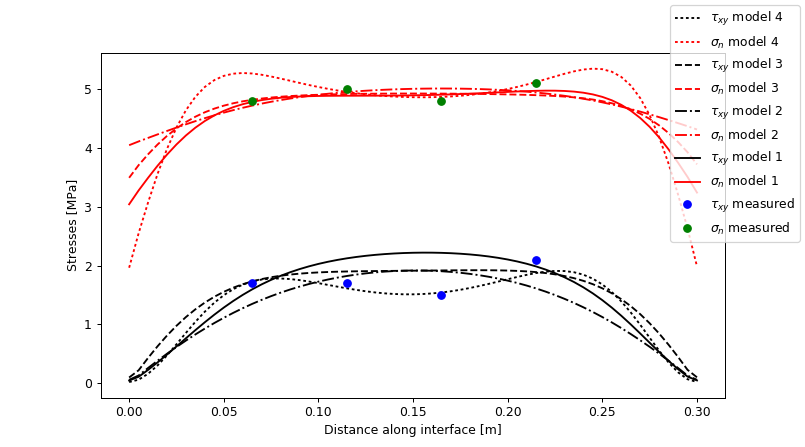

In [7]:
%matplotlib notebook
## recap of all the models
f8=plt.figure(8,figsize=(9,5))
ax8=f8.add_subplot(111) # we choose to plot the positive values
# model 1
l81s,=ax8.plot(setup1.coordx,-output1.shear_half*10**-6,':k')
l81n,=ax8.plot(setup1.coordx,-output1.normal_half*10**-6,':r')
# model 2
l82s,=ax8.plot(setup2.coordx,-output2.shear_half*10**-6,'--k')
l82n,=ax8.plot(setup2.coordx,-output2.normal_half*10**-6,'--r')
# model 3
l83s,=ax8.plot(setup3.coordx,-output3.shear_half*10**-6,'-.k')
l83n,=ax8.plot(setup3.coordx,-output3.normal_half*10**-6,'-.r')
# model 4
l84s,=ax8.plot(setup4.coordx,-output4.shear_half*10**-6,'k')
l84n,=ax8.plot(setup4.coordx,-output4.normal_half*10**-6,'r')
# measured values
l83,=ax8.plot(x_horiz_nmn,-horiz_nmn*10**-6,'ob')
l84,=ax8.plot(x_horiz_nmn,-vert_nmn*10**-6,'og')

ax8.set_ylabel('Stresses [MPa]')
ax8.set_xlabel('Distance along interface [m]')
f8.legend((l81s,l81n,l82s,l82n,l83s,l83n,l84s,l84n,l83,l84), (r'$\tau_{xy}$ model 4', r'$\sigma_n$ model 4', \
                                                              r'$\tau_{xy}$ model 3', r'$\sigma_n$ model 3', \
                                                              r'$\tau_{xy}$ model 2', r'$\sigma_n$ model 2', \
                                                              r'$\tau_{xy}$ model 1', r'$\sigma_n$ model 1', \
                                                              r'$\tau_{xy}$ measured',r'$\sigma_n$ measured'))
#f8.suptitle('Models')

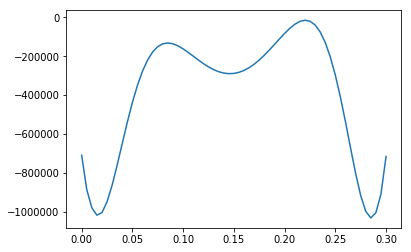

In [70]:
# %matplotlib inline
plt.plot(setup1.coordx,-output1.shear_half+0.37*output1.normal_half)

In [8]:
#setup1=setup(nelx,nely,width,heigth,E,nu)
setup12=setup(60,30,0.30,0.075,3.0e9,0.35)# Why changing E doesn't change anything???

BC_dofs12=[[1,8],[4,5]] 

BC_val12=[['0.0*np.ones((len(dofs1)))', \
         '0.0*np.ones((len(dofs8)))'], \
        ['np.ones((len(dofs4)))*output1.shear_half*setup12.el_width', \
        'np.ones((len(dofs5)))*output1.normal_half*setup12.el_width']]        
#----------------------------------------------------------------------#
### results we need to plot solution:
output12=output(setup12,setup12.kbase(),BC_dofs12,BC_val12,P_horiz,P_vert,0,0)

<IPython.core.display.Javascript object>


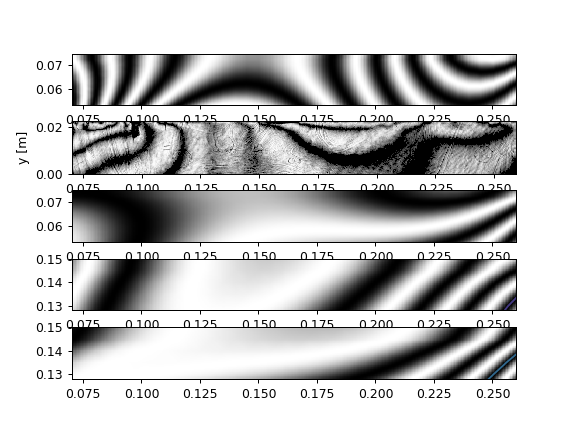

In [9]:
outputi=output12
setupi=setup12
###############2nd part, fringes
sigma=outputi.sigma
U=outputi.U
coord=setupi.coord
nelx=setupi.nelx
nely=setupi.nely
width=setupi.width
heigth=setupi.heigth

h=0.01
fs=4000.0
## new finer grid to obtain smoother fringe pattern
nx=500
ny=500
xx=np.linspace(0,width,nx)
yy=np.linspace(0,heigth,ny)
[XX,YY]=np.meshgrid(xx,yy)


from matplotlib.mlab import griddata
N_frg_new = griddata((coord[:,0]), (coord[:,1]), \
                     N_frg(sigma,h,fs).reshape(((nelx+1)*(nely+1))), \
                     xx, yy, interp='linear')

inty_new=np.sin(N_frg_new * np.pi)**2
#f7=plt.figure(7,figsize=(10,6))

f66=plt.figure(66)#,figsize=(10,6))
ax7=f66.add_subplot(511)
ax7.pcolormesh(XX,YY,inty_new.reshape((ny,nx)),cmap='gray')
ax7.set_aspect('equal')
#ax7.set_title('model 4')
CS = ax7.contour((coord[:,0]+U[::2]).reshape((nely+1, nelx+1)), \
                       (coord[:,1]+U[1::2]).reshape((nely+1, nelx+1)), \
                        N_frg(sigma,h,fs) )
ax7.clabel(CS, inline=1, fontsize=10)

ax7.set_xlim(left=0.0702, right=0.26)
ax7.set_ylim([heigth-0.022,heigth])

## comparison with a real picture ------------------------------------
import imageio
file_path='32.png'
im = imageio.imread(file_path)
im=np.array(im)[:,:,0]

ax63=f66.add_subplot(512)
ax63.pcolor(np.transpose(im))
ax63.set_aspect('equal')
# ax82=f8.add_subplot(212)

## part to rescale the picture (also to run only once, or after having reset the points)
ax63.clear() # or ax12.cla()

##rescale the picture
y=np.arange(0,im.shape[0],1)
x=np.arange(0,im.shape[1],1)
xpcal=[96,194]
ypcal=[0,0]

xcal=((x)/(xpcal[1]-xpcal[0])*0.04)
ycal=((y)/(xpcal[1]-xpcal[0])*0.04)+0.0702

[X,Y]=np.meshgrid(xcal,ycal)
# f2=plt.figure(2)
# ax2=f2.add_subplot(111)
ax63.pcolor(Y,X,im,cmap='gray')
ax63.set_aspect('equal')
ax63.set_xlabel('x [m]')
ax63.set_ylabel('y [m]')
#ax63.set_title('calibrated picture')
#ax81.set_ylim(ax81.get_ylim()[::-1])

In [10]:
#setup1=setup(nelx,nely,width,heigth,E,nu)
setup22=setup(60,30,0.30,0.075,3.0e9,0.35)

BC_dofs22=[[0,1],[4,5]] 

BC_val22=[['0.0*np.ones((len(dofs0)))', \
         '0.0*np.ones((len(dofs1)))'], \
        ['np.ones((len(dofs4)))*output2.shear_half*setup22.el_width', \
        'np.ones((len(dofs5)))*output2.normal_half*setup22.el_width']]        
#----------------------------------------------------------------------#
### results we need to plot solution:
output22=output(setup22,setup22.kbase(),BC_dofs22,BC_val22,P_horiz,P_vert,0,0)

In [11]:
outputi=output22
setupi=setup22
###############2nd part, fringes
sigma=outputi.sigma
U=outputi.U
coord=setupi.coord
nelx=setupi.nelx
nely=setupi.nely
width=setupi.width
heigth=setupi.heigth

xx=np.linspace(0,width,nx)
yy=np.linspace(0,heigth,ny)
[XX,YY]=np.meshgrid(xx,yy)

N_frg_new = griddata((coord[:,0]), (coord[:,1]), \
                     N_frg(sigma,h,fs).reshape(((nelx+1)*(nely+1))), \
                     xx, yy, interp='linear')

inty_new=np.sin(N_frg_new * np.pi)**2
#f7=plt.figure(7,figsize=(10,6))

ax72=f66.add_subplot(513)
ax72.pcolormesh(XX,YY,inty_new.reshape((ny,nx)),cmap='gray')
ax72.set_aspect('equal')
#ax72.set_title('model 3')
CS = ax72.contour((coord[:,0]+U[::2]).reshape((nely+1, nelx+1)), \
                       (coord[:,1]+U[1::2]).reshape((nely+1, nelx+1)), \
                        N_frg(sigma,h,fs) )
ax72.clabel(CS, inline=1, fontsize=10)

ax72.set_xlim(left=0.0702, right=0.26)
ax72.set_ylim([heigth-0.022,heigth])
#f66.tight_layout()

(0.053, 0.075)

In [12]:

#setup1=setup(nelx,nely,width,heigth,E,nu)
setup32=setup(60,30,0.30,0.15,3.0e9,0.35)

BC_dofs32=[[0,1],[4,5]] 

BC_val32=[['0.0*np.ones((len(dofs0)))', \
         '0.0*np.ones((len(dofs1)))'], \
        ['np.ones((len(dofs4)))*output3.shear_half*setup32.el_width', \
        'np.ones((len(dofs5)))*output3.normal_half*setup32.el_width']]        
#----------------------------------------------------------------------#
### results we need to plot solution:
output32=output(setup32,setup32.kbase(),BC_dofs32,BC_val32,P_horiz,P_vert,0,0)

In [13]:
outputi=output32
setupi=setup32
###############2nd part, fringes
sigma=outputi.sigma
U=outputi.U
coord=setupi.coord
nelx=setupi.nelx
nely=setupi.nely
width=setupi.width
heigth=setupi.heigth

xx=np.linspace(0,width,nx)
yy=np.linspace(0,heigth,ny)
[XX,YY]=np.meshgrid(xx,yy)

N_frg_new = griddata((coord[:,0]), (coord[:,1]), \
                     N_frg(sigma,h,fs).reshape(((nelx+1)*(nely+1))), \
                     xx, yy, interp='linear')

inty_new=np.sin(N_frg_new * np.pi)**2
#f7=plt.figure(7,figsize=(10,6))

ax73=f66.add_subplot(514)
ax73.pcolormesh(XX,YY,inty_new.reshape((ny,nx)),cmap='gray')
ax73.set_aspect('equal')
#ax73.set_title('model 2')
CS = ax73.contour((coord[:,0]+U[::2]).reshape((nely+1, nelx+1)), \
                       (coord[:,1]+U[1::2]).reshape((nely+1, nelx+1)), \
                        N_frg(sigma,h,fs) )
ax73.clabel(CS, inline=1, fontsize=10)

ax73.set_xlim(left=0.0702, right=0.26)
ax73.set_ylim([heigth-0.022,heigth])
#f66.tight_layout()

(0.128, 0.15)

In [14]:
#setup1=setup(nelx,nely,width,heigth,E,nu)
setup42=setup(60,30,0.30,0.15,3.0e9,0.35)

BC_dofs42=[[1,8],[4,5]] #we always give the displacements first, then the forces
## here all the BC values must be expression giving vectors
## to give pressure we must normalize in those expressions 
## by th length of elements (height or width)
BC_val42=[['0.0*np.ones((len(dofs1)))', \
         '0.0*np.ones((len(dofs8)))'], \
        ['np.ones((len(dofs4)))*output4.shear_half*setup42.el_width', \
        'np.ones((len(dofs5)))*output4.normal_half*setup42.el_width']]
output42=output(setup42,setup42.kbase(),BC_dofs42,BC_val42,P_horiz,P_vert,0.075,0.075)

In [15]:
outputi=output42
setupi=setup42
###############2nd part, fringes
sigma=outputi.sigma
U=outputi.U
coord=setupi.coord
nelx=setupi.nelx
nely=setupi.nely
width=setupi.width
heigth=setupi.heigth

xx=np.linspace(0,width,nx)
yy=np.linspace(0,heigth,ny)
[XX,YY]=np.meshgrid(xx,yy)

N_frg_new = griddata((coord[:,0]), (coord[:,1]), \
                     N_frg(sigma,h,fs).reshape(((nelx+1)*(nely+1))), \
                     xx, yy, interp='linear')

inty_new=np.sin(N_frg_new * np.pi)**2
#f7=plt.figure(7,figsize=(10,6))

ax74=f66.add_subplot(515)
ax74.pcolormesh(XX,YY,inty_new.reshape((ny,nx)),cmap='gray')
ax74.set_aspect('equal')
#ax74.set_title('model 1')
CS = ax74.contour((coord[:,0]+U[::2]).reshape((nely+1, nelx+1)), \
                       (coord[:,1]+U[1::2]).reshape((nely+1, nelx+1)), \
                        N_frg(sigma,h,fs) )
ax74.clabel(CS, inline=1, fontsize=10)

ax74.set_xlim(left=0.0702, right=0.26)
ax74.set_ylim([heigth-0.022,heigth])
#f66.tight_layout()

(0.128, 0.15)

<IPython.core.display.Javascript object>


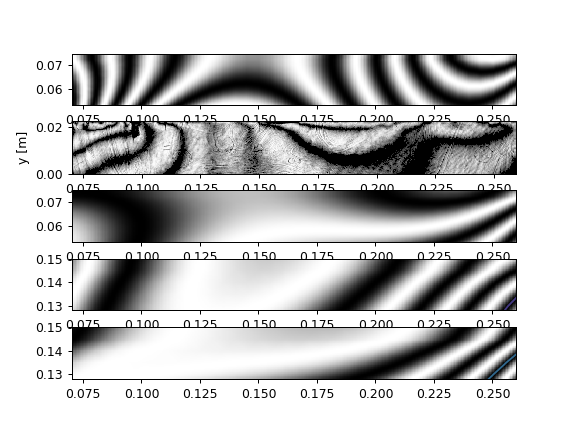

In [16]:
f66

<IPython.core.display.Javascript object>


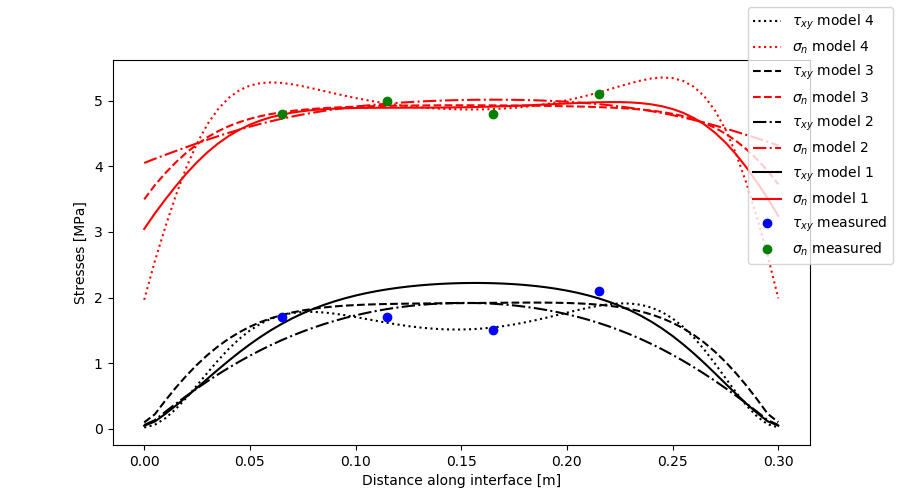

In [30]:
f8